# Figure Creator

In [293]:
import time
import json  # for checkpointing
import csv

from collections import Counter

from pathlib import Path

import numpy as np
# import scipy.sparse
# import torch
# import torch.nn.functional as F
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors
from tqdm.notebook import trange, tqdm

import pandas as pd

# import datetime

# import os
# from dotenv import load_dotenv, find_dotenv

from timeit import default_timer as timer

# load_dotenv(find_dotenv('config.env'))

# torch.cuda.current_device()
# torch.cuda.device(0)
# torch.cuda.device_count()
# torch.cuda.get_device_name(0)
# torch.cuda.is_available()

# import sklearn
# import sklearn.metrics
import seaborn as sns

In [255]:
def seconds_to_hhmmss(s):
    seconds = s
    minutes = seconds // 60
    hours = minutes // 60
    return "%02d:%02d:%02d" % (hours, minutes % 60, seconds % 60)

# Selected Model Loading

In [283]:
df0 = pd.read_csv('model_checkpoints/mha_pool_imbalanced_val_2021-05-01/summary.csv')  # SWITCH
df1 = pd.read_csv('model_checkpoints/mha_pool_balanced_val_2021-04-30/summary.csv')    # SWITCH
df2 = pd.read_csv('model_checkpoints/first_mha_2021-04-20/summary.csv')    # SWITCH
df3 = pd.read_csv('model_checkpoints/balanced_good_2021-04-19/summary.csv')    # SWITCH

# Model Training/Validation Results Table

In [271]:
df0 = pd.read_csv('model_checkpoints/mha_pool_imbalanced_val_2021-05-01/summary.csv')
df0['model'] = 'MHA-34-Discard'
df0 = df0[['model',
    'epoch', 
    'train_loss',
    'train_acc',
    'val_loss',
    'val_acc',
    'time_elapsed']]


df1 = pd.read_csv('model_checkpoints/mha_pool_balanced_val_2021-04-30/summary.csv')
df1['model'] = 'MHA-34-Pool'
df1 = df1[['model',
    'epoch', 
    'train_loss',
    'train_acc',
    'val_loss',
    'val_acc',
    'time_elapsed']]

df = pd.concat([df0, df1]).set_index(['model', 'epoch'])
df

train_loss  train_acc  val_loss   val_acc time_elapsed
model          epoch                                                        
MHA-34-Discard 0        1.932224   0.392192  1.251288  0.562624     01:04:00
               1        1.229906   0.568541  1.149642  0.587195     01:04:13
               2        1.139476   0.595792  1.073722  0.612338     01:04:10
               3        1.088838   0.611396  1.040218  0.623755     01:04:47
               4        1.052727   0.622851  1.032041  0.628674     01:04:23
               5        1.027033   0.630922  0.994944  0.637235     01:04:34
               6        1.007839   0.636934  0.970936  0.644726     01:04:12
               7        0.992579   0.641533  0.952678  0.652323     01:04:45
               8        0.980189   0.645401  0.951607  0.650489     01:04:57
               9        0.969709   0.648484  0.960522  0.647058     01:05:13
               10       0.960662   0.651278  0.941569  0.654038     01:04:46
               11       0.952840   0.653680  0.925829  0.659700     01:04:41
               12       0.945879   0.655778  0.931133  0.657469     01:04:28
               13       0.939770   0.657584  0.936935  0.654948     01:04:16
               14       0.934013   0.659377  0.957173  0.647447     01:04:46
MHA-34-Pool    0        1.932224   0.392192  1.317855  0.542066     01:06:19
               1        1.229906   0.568541  1.189308  0.578356     01:08:21
               2        1.139476   0.595792  1.120268  0.600655     01:05:14
               3        1.088838   0.611396  1.083478  0.611872     01:05:04
               4        1.052727   0.622851  1.057816  0.621912     01:05:20
               5        1.027033   0.630922  1.027994  0.628478     01:05:27
               6        1.007839   0.636934  1.011413  0.634754     01:05:22
               7        0.992579   0.641533  0.994163  0.639680     01:05:52
               8        0.980189   0.645401  0.982160  0.642516     01:05:48
               9        0.969709   0.648484  0.979542  0.643872     01:06:03
               10       0.960662   0.651278  0.966473  0.647996     01:05:59
               11       0.952840   0.653680  0.965144  0.649107     01:06:11
               12       0.945879   0.655778  0.966738  0.648672     01:05:38

In [272]:
# Get Average Time/Epoch
df['time_elapsed'] = pd.to_timedelta(df['time_elapsed'])
avg_time = df.groupby('model')['time_elapsed'].mean(numeric_only=False)
avg_time = avg_time.dt.seconds.apply(seconds_to_hhmmss)

# Get Model rows with lowest val_loss
new = df.loc[df.groupby('model')['val_loss'].idxmin()]
new = new.drop(columns='time_elapsed')
new = new.reset_index().set_index('model')

# Merge calculated average time
new['avg_time_per_epoch'] = avg_time
new = new.reset_index()  # Makes index printing leveled with other columns
new

,model,epoch,train_loss,train_acc,val_loss,val_acc,avg_time_per_epoch
0,MHA-34-Discard,11,0.95284,0.65368,0.925829,0.659700,01:04:32
1,MHA-34-Pool,11,0.95284,0.65368,0.965144,0.649107,01:05:53


In [273]:

lstr = new.to_latex(index=False,
                    index_names=False, 
                    float_format="%.3f", 
                    bold_rows=True,
                   )

print(lstr)

\begin{tabular}{lrrrrrl}
\toprule
          model &  epoch &  train\_loss &  train\_acc &  val\_loss &  val\_acc & avg\_time\_per\_epoch \\
\midrule
 MHA-34-Discard &     11 &       0.953 &      0.654 &     0.926 &    0.660 &           01:04:32 \\
    MHA-34-Pool &     11 &       0.953 &      0.654 &     0.965 &    0.649 &           01:05:53 \\
\bottomrule
\end{tabular}



# Model Graph

In [301]:
# sns.set_style("ticks")
# sns.set_style("darkgrid", {"axes.facecolor": ".9"})
# sns.set_style("whitegrid")
sns.set_style("darkgrid")

sns.set_palette('bright')

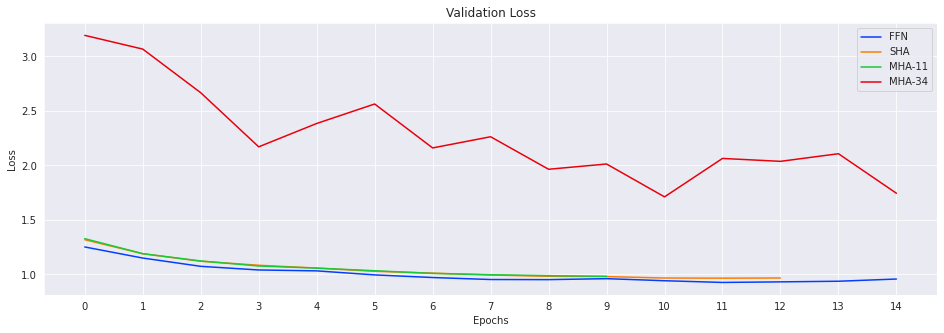

In [302]:
figure = plt.figure(figsize=(16, 5))

plt.plot(df0['val_loss'][0:15], label='FFN')
plt.plot(df1['val_loss'][0:15], label='SHA')
plt.plot(df2['val_loss'][0:15], label='MHA-11')
plt.plot(df3['val_loss'][0:15], label='MHA-34')

plt.title('Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.xticks(range(15))

plt.show()

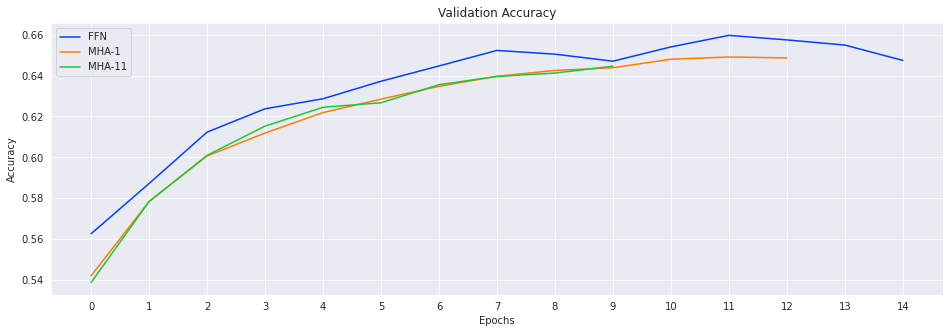

In [303]:
figure = plt.figure(figsize=(16, 5))

plt.plot(df0['val_acc'][0:15], label='FFN')
plt.plot(df1['val_acc'][0:15], label='MHA-1')
plt.plot(df2['val_acc'][0:15], label='MHA-11')
# plt.plot(df3['val_acc'][0:15], label='MHA-34')

plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# plt.yticks(np.arange(0, 1, 0.1))

plt.xticks(range(15))

plt.show()

# Best Discard Format

### TODO: LOAD CHOSEN MODEL

In [306]:
df_pools_only = pd.read_csv('model_checkpoints/mha_pool_balanced_val_2021-04-30/summary.csv')
df_pools_meld = pd.read_csv('model_checkpoints/mha_pool_imbalanced_val_2021-05-01/summary.csv')

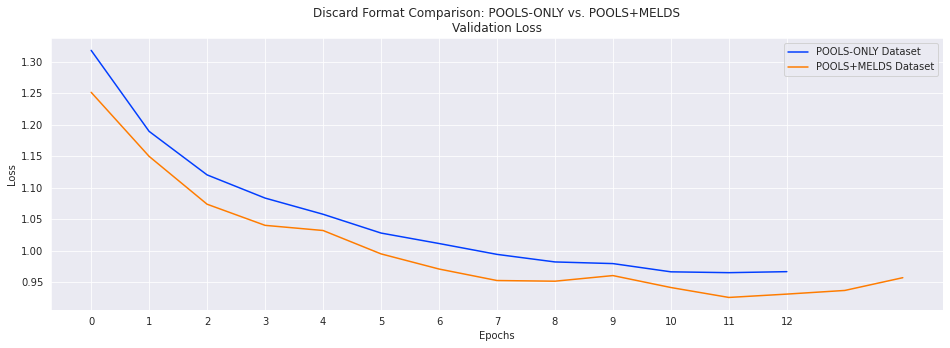

In [312]:
figure = plt.figure(figsize=(16, 5))

plt.plot(df_pools_only['epoch'], df_pools_only['val_loss'], label='POOLS-ONLY Dataset')
plt.plot(df_pools_meld['epoch'], df_pools_meld['val_loss'], label='POOLS+MELDS Dataset')

plt.title('Discard Format Comparison: POOLS-ONLY vs. POOLS+MELDS\nValidation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.xticks(df1['epoch'])

plt.show()

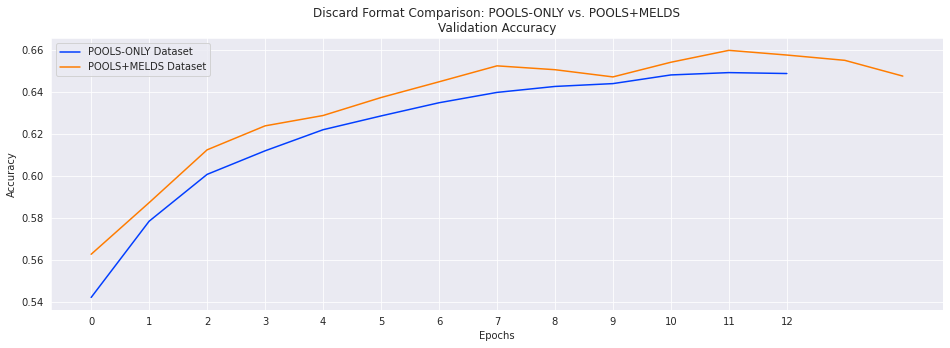

In [313]:
figure = plt.figure(figsize=(16, 5))

plt.plot(df_pools_only['epoch'], df_pools_only['val_acc'], label='POOLS-ONLY Dataset')
plt.plot(df_pools_meld['epoch'], df_pools_meld['val_acc'], label='POOLS+MELDS Dataset')

plt.title('Discard Format Comparison: POOLS-ONLY vs. POOLS+MELDS\nValidation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.xticks(df1['epoch'])

plt.show()